In [51]:
# Load packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/usprovinces/USProvinceData.csv
/kaggle/input/usstates-more/us-states.csv
/kaggle/input/covid19data/time_series_covid19_deaths_US.csv
/kaggle/input/covid19data/4.18states.csv
/kaggle/input/covid19data/abridged_couties.csv
/kaggle/input/covid19data/time_series_covid19_confirmed_US.csv


In [52]:
# Load US state code and the confirmed cases of each states on 4/18, and fill the Nan of Mortality_Rate with 0.
USstates = pd.read_csv("/kaggle/input/usprovinces/USProvinceData.csv")
df_states = pd.read_csv("/kaggle/input/covid19data/4.18states.csv")
df_states['Mortality_Rate'] = df_states['Mortality_Rate'].fillna(0)
df_states.head(5)

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,0.000000,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


In [53]:
# Merge two table, give each states corresponding code for later map graph. Dividing the table into mortality table and confirmed table.
df_states = df_states.merge(USstates, left_on='Province_State', right_on='State')
df_states_mortality = df_states[['Province_State','Mortality_Rate','Code']]
df_states_confirmed = df_states[['Province_State','Confirmed','Code']]
df_states_confirmed.head(5)

,Province_State,Confirmed,Code
0,Alabama,4712,AL
1,Alaska,314,AK
2,Arizona,4724,AZ
3,Arkansas,1744,AR
4,California,30491,CA


In [10]:
# The map graph of current confirmed cases of each states in US.
fig = px.choropleth(df_states_confirmed, locations = 'Code', locationmode="USA-states", color= 'Confirmed', scope= "usa", color_continuous_scale="peach", title = "Confirmed cases in US")
fig.show()

In [9]:
# The map graph of current mortality rate of each states in US.
fig = px.choropleth(df_states_mortality, locations = 'Code', locationmode="USA-states", color= 'Mortality_Rate', scope= "usa", color_continuous_scale="reds", title = "Mortality rate in US")
fig.show()

In [55]:
# Data cleaning of time_counties, in order to provied confirmed case for each couties
time_counties = pd.read_csv("/kaggle/input/covid19data/time_series_covid19_confirmed_US.csv")
time_counties = time_counties[['FIPS','Province_State','Admin2','4/18/20']]
time_counties = time_counties.dropna(subset=['FIPS'])
time_counties['FIPS'] = time_counties['FIPS'].astype(int)
time_counties .head(5)

,FIPS,Province_State,Admin2,4/18/20
0,60,American Samoa,NaN,0
1,66,Guam,NaN,136
2,69,Northern Mariana Islands,NaN,14
3,72,Puerto Rico,NaN,1118
4,78,Virgin Islands,NaN,53


In [57]:
# Data cleaning of counties, selecting useful features and merge with time_series to see the ratio of confirmed cases and total population.
# Add more columns for some may useful features, like ratio of ICU beds over confirmed cases. 
# Only keeps the counties with confirmed percentage over 0.5 for clear scatter plot later.
counties = pd.read_csv("/kaggle/input/covid19data/abridged_couties.csv")
counties = counties.drop(['STATEFP', 'COUNTYFP', 'lat','lon','POP_LATITUDE','POP_LONGITUDE'], axis=1)
counties = counties[['countyFIPS','CountyName','State','PopulationEstimate2018', '#FTEHospitalTotal2017','#Hospitals', '#ICU_beds','SVIPercentile','#EligibleforMedicare2018','dem_to_rep_ratio','PopulationDensityperSqMile2010']]
counties = counties.drop([3242, 3243])
counties['countyFIPS'] = counties['countyFIPS'].astype(int)
counties = counties.merge(time_counties, left_on='countyFIPS', right_on='FIPS')
counties = counties.drop(['Province_State','FIPS','Admin2'], axis=1)
counties = counties.dropna(subset=['State'])
counties['ICU_Bed_Ratio'] = (counties['#ICU_beds'] / counties['4/18/20'] ) * 100  
counties['Hos_Employee_Ratio'] = (counties['#FTEHospitalTotal2017'] / counties['4/18/20']) * 100
counties['Medicare_Ratio'] = (counties['#EligibleforMedicare2018'] / counties['PopulationEstimate2018']) * 100
counties['Percentage'] =  (counties['4/18/20'] / counties['PopulationEstimate2018'] ) * 100
counties = counties.sort_values(by=['Percentage'], ascending=False)
counties = counties.iloc[1:]
counties = counties[counties['Percentage']>= 0.5]
counties.head(5)

,countyFIPS,CountyName,State,PopulationEstimate2018,#FTEHospitalTotal2017,#Hospitals,#ICU_beds,SVIPercentile,#EligibleforMedicare2018,dem_to_rep_ratio,PopulationDensityperSqMile2010,4/18/20,ICU_Bed_Ratio,Hos_Employee_Ratio,Medicare_Ratio,Percentage
1862,36087,Rockland,New York,325695.0,4913.0,3.0,39.0,0.6038,59287.0,1.138415,1796.0,9171,0.425254,53.571039,18.203227,2.815825
1878,36119,Westchester,New York,967612.0,18781.0,9.0,179.0,0.5516,182351.0,2.079626,2204.7,23179,0.772251,81.025929,18.845467,2.395485
1848,36059,Nassau,New York,1358343.0,46958.0,10.0,461.0,0.2430,276379.0,1.131021,4704.8,29180,1.579849,160.925291,20.346775,2.148206
548,16013,Blaine,Idaho,22601.0,364.0,1.0,0.0,0.3239,4927.0,1.920958,8.1,475,0.000000,76.631579,21.799920,2.101677
498,13243,Randolph,Georgia,6833.0,283.0,1.0,0.0,0.9739,1724.0,1.257278,18.0,141,0.000000,200.709220,25.230499,2.063515


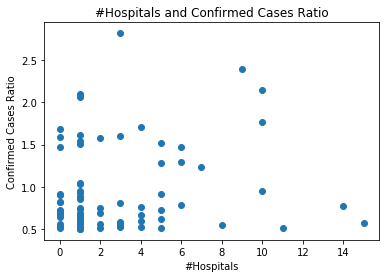

In [58]:
# Analyze the potential relation bewteen number of hosptial and confirmed cases ratio of each counties, using scatter plot.
plt.scatter(counties['#Hospitals'], counties['Percentage'])
plt.title("#Hospitals and Confirmed Cases Ratio")
plt.xlabel('#Hospitals')
plt.ylabel('Confirmed Cases Ratio')
plt.show()

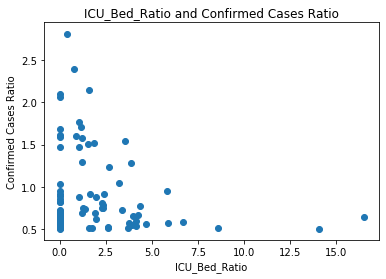

In [59]:
# Analyze the potential relation bewteen ratio of ICU beds over confirmed people and confirmed cases ratio of each counties, using scatter plot.
plt.scatter(counties['ICU_Bed_Ratio'], counties['Percentage'])
plt.title("ICU_Bed_Ratio and Confirmed Cases Ratio")
plt.xlabel('ICU_Bed_Ratio')
plt.ylabel('Confirmed Cases Ratio')
plt.show()

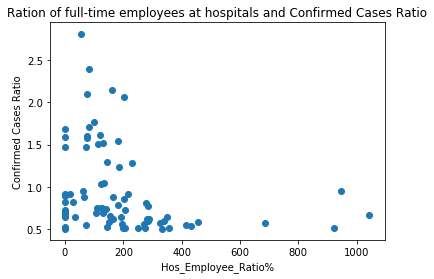

In [60]:
# Analyze the potential relation bewteen ratio of hosptial employees over confirmed people and confirmed cases ratio of each counties, using scatter plot.
plt.scatter(counties['Hos_Employee_Ratio'], counties['Percentage'])
plt.title("Ration of full-time employees at hospitals and Confirmed Cases Ratio")
plt.xlabel('Hos_Employee_Ratio%')
plt.ylabel('Confirmed Cases Ratio')
plt.show()

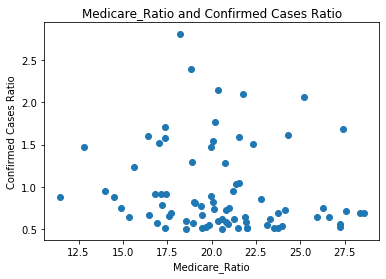

In [61]:
# Analyze the potential relation bewteen Medicare_Ratio and confirmed cases ratio of each counties, using scatter plot.
plt.scatter(counties['Medicare_Ratio'], counties['Percentage'])
plt.title("Medicare_Ratio and Confirmed Cases Ratio")
plt.xlabel('Medicare_Ratio')
plt.ylabel('Confirmed Cases Ratio')
plt.show()

In [12]:
# Import time_series_covid19_confirmed_US and drop unnecessary column
# Group by states to see the total confirmed cases and sort by order based on that.
time_con = pd.read_csv("/kaggle/input/covid19data/time_series_covid19_confirmed_US.csv")
time_con = time_con.drop(['UID', 'code3', 'FIPS', 'Lat','Long_'], axis = 1)
time_con = time_con.groupby('Province_State', as_index=False).sum()
time_con = time_con.sort_values(by=['4/18/20'], ascending=False)
time_con.head(5)

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
36,New York,0,0,0,0,0,0,0,0,0,...,161779,172348,181026,189033,195749,203020,214454,223691,230597,241712
34,New Jersey,0,0,0,0,0,0,0,0,0,...,51027,54588,58151,61850,64584,68824,71030,75317,78467,81420
25,Massachusetts,0,0,0,0,0,0,0,0,0,...,18941,20974,22860,25475,26867,28164,29918,32181,34402,36372
43,Pennsylvania,0,0,0,0,0,0,0,0,0,...,18300,20051,21719,22938,24292,25465,26753,28258,29888,31652
26,Michigan,0,0,0,0,0,0,0,0,0,...,21504,22434,23605,24244,25635,27001,28059,28809,30023,30791


In [23]:
# Creat table for only the top two states,and sum their cases with a new row named "NY&NJ" 
# Drop all columns with 0 confirmed cases and only keeps "NY&NJ"
time_con_first = time_con.head(2)
time_east= time_con_first.append(time_con_first.sum(numeric_only=True), ignore_index=True)
time_east.replace(np.nan, 'NY&NJ', inplace=True)
time_east = time_east.loc[:, (time_east != 0).any(axis=0)]
time_east = time_east.iloc[2:]
time_east

,Province_State,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
2,NY&NJ,1.0,2.0,11.0,25.0,33.0,80.0,111.0,147.0,165.0,...,212806.0,226936.0,239177.0,250883.0,260333.0,271844.0,285484.0,299008.0,309064.0,323132.0


In [47]:
# Load more data about confirmed cases of each states, keep only the data about NY and NJ.
# Keep only the data after 4/18, get the sum result, and tranpose the table as the one above.
more_states = pd.read_csv("/kaggle/input/usstates-more/us-states.csv")
more_nynj = more_states[(more_states['state'] == "New York") |(more_states['state'] == "New Jersey")]
more_nynj = more_nynj.iloc[95:].drop(['fips', 'deaths'], axis=1)
more_nynj = more_nynj.groupby('date', as_index=False).sum()
more_nynj = more_nynj.rename(columns={'cases':'NY&NJ'})
more_nynj = more_nynj.set_index('date')
more_nynj = more_nynj.transpose()
more_nynj

date,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07
NY&NJ,332042,340414,348319,357456,367921,378414,392424,401952,408179,414132,421258,428348,434765,441851,448577,452626,457252,461295,466566


In [32]:
# Get length of provied date and newly import data
# Transfer the date info into int. Where 1 is date 3/2/20, and 67 is 5/7/20
lenold = len(time_east.columns) - 1
lenmore = len(more_nynj.columns)
total = lenold + lenmore
X_tr = np.arange(1, lenold + 1) # Train set range(old provied date)
X_te = np.arange(lenold + 1, total + 1) # Test set range (new import data)

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67])

In [34]:
# Set the PolynomialFeatures with degree of 3, and get the fitted X_train, X_test
# Get the Y_train and Y_test where train is the confirmed cases of NY&NJ in the old provied dataset, the test is the new import data. 
poly = PolynomialFeatures(degree = 3) 
X_train=poly.fit_transform(X_tr.reshape(-1,1))
X_test = poly.fit_transform(X_te.reshape(-1,1))
Y_train = time_east.drop(columns=['Province_State']).to_numpy()[0]
Y_test = more_nynj.loc['NY&NJ'].to_numpy()

In [36]:
# Fit the LinearRegression model with normaliztion 
linreg=LinearRegression(normalize=True)
linreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [37]:
# Find the RMSE of train and test
def rmse(actual, predicted):
    return (sum((actual-predicted)**2)/len(actual))**(1/2)

Ytr_pre=linreg.predict(X_train)
Y_pred=linreg.predict(X_test)

training_error = rmse(Y_train, Ytr_pre)
test_error = rmse(Y_test,Y_pred)

print("Training Error: ", training_error)
print("Test Error: ", test_error)

Training Error:  7051.227062626601
Test Error:  106340.85632078265


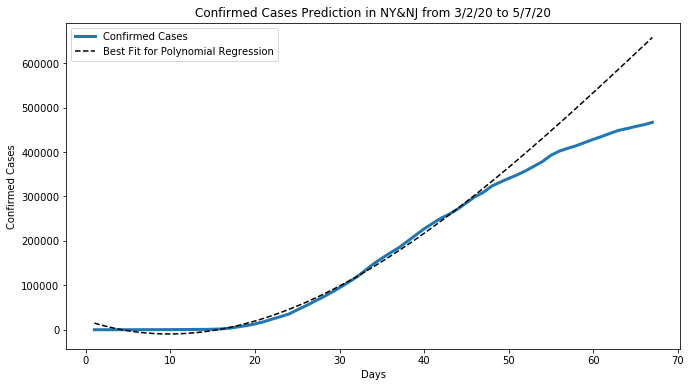

In [48]:
# Plot to see how well the model performs all data.
X_range = np.arange(1, total + 1)
X_all = poly.fit_transform(X_range.reshape(-1,1))
Y_all = np.append(Y_train, Y_test)
Y_pre = linreg.predict(X_all)

plt.figure(figsize=(11,6))
plt.plot(X_range,Y_all,label="Confirmed Cases",linewidth=3)
plt.plot(X_range,Y_pre, linestyle='--',label="Best Fit for Polynomial Regression",color='black')
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Prediction in NY&NJ from 3/2/20 to 5/7/20")
plt.legend()

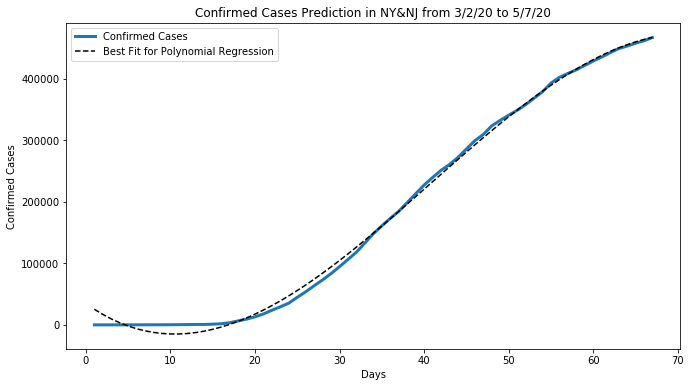

In [49]:
# Re-fit model with all data and plot it out to see that prediction is more accurate. 
new_linreg=LinearRegression(normalize=True)
new_linreg.fit(X_all,Y_all)
Y_pre = new_linreg.predict(X_all)

plt.figure(figsize=(11,6))
plt.plot(X_range,Y_all,label="Confirmed Cases",linewidth=3)
plt.plot(X_range,Y_pre, linestyle='--',label="Best Fit for Polynomial Regression",color='black')
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Prediction in NY&NJ from 3/2/20 to 5/7/20")
plt.legend()
